In [3]:
import math
import psutil
import dask
import dask.dataframe as dd
import multiprocessing 
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Show number of cores of the laptop
print(multiprocessing.cpu_count())

4


In [5]:
print(f"Total RAM Installed: {round(psutil.virtual_memory().total/1000000000, 2)} GB")
print(f"Available RAM : {round(psutil.virtual_memory().available/1000000000, 2)} GB")
print(f"Used RAM: {round(psutil.virtual_memory().used/1000000000, 2)} GB")
print(f"RAM Usage : {psutil.virtual_memory().percent} %")

Total RAM Installed: 12.78 GB
Available RAM : 4.81 GB
Used RAM: 7.97 GB
RAM Usage : 62.4 %


In [6]:
dask.config.set(scheduler='multiprocessing')
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=4, memory_limit = '4GB')
# explicitly connect to the cluster just created
client = Client(cluster)
# Viewing the client and the cluster
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:1780,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:1790,Total threads: 4
Dashboard: http://127.0.0.1:1791/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:1783,


In [7]:
ML_pollution_dd=dd.read_csv("F:\Documents\MSc Data Science & Analytics\Distributed Data Analysis\Coding\Reduced Pollution Dataset.csv",
                        dtype = 
                        {'PM10': 'float64',
                        'SO2': 'float64',
                        'O3': 'float64',
                        'NO2': 'float64'})
ML_pollution_dd.head(n=5)

,Unnamed: 0,PC1,PC2,PC3,PC4,PM10
0,1,0.421050,-3.569345,-0.166368,-0.353392,4.0
1,2,0.405010,-3.679821,-0.211176,-0.445583,8.0
2,3,0.419814,-3.972367,-0.365826,-0.741313,7.0
3,4,0.820573,-3.004630,-0.026597,-0.066497,6.0
4,5,0.994147,-2.589963,0.157487,0.277241,3.0


In [8]:
pollution = ML_pollution_dd.compute()
ML_pollution_partitioned = dd.from_pandas(pollution, npartitions=20)

In [9]:
def pollution_NN(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error = []
    
 
    NN_model = MLPRegressor(hidden_layer_sizes = (5), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred = NN_model.predict(xtest)
        
        
    # Compute errors
    error = mean_squared_error(ytest.values.ravel(), NN_pred)
    MSE_error.append(error)
    
        
    return error

In [12]:
p1 = ML_pollution_partitioned .map_partitions(pollution_NN, meta = (None, 'int64'))
one_hiddenlayer_error = p1.compute()
one_hiddenlayer_error

0     2444.563406
1     1938.254151
2     1822.038593
3     1652.659926
4     1671.159599
5     2415.348279
6     1975.588634
7     2130.412629
8     2340.563649
9     2048.444956
10    1912.914979
11    1824.431983
12    1905.816390
13    2054.259350
14    1934.005737
15    2253.503916
16    2108.628182
17    2343.363865
18    2255.459297
19    1776.982788
dtype: float64

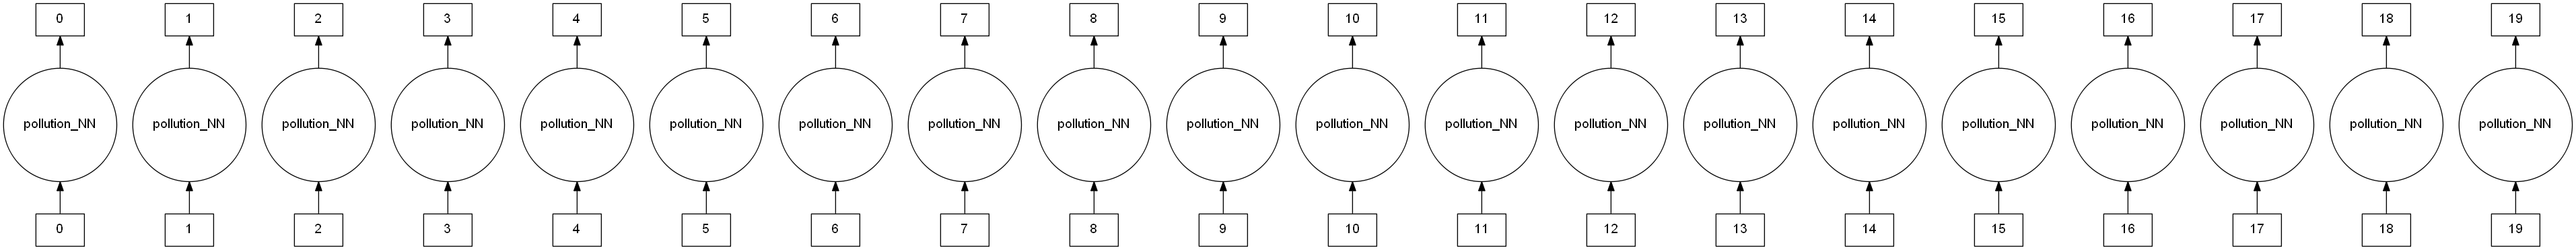

In [24]:
p1.visualize()

In [25]:
# Calculating the average of error for all partitions
partition_mean1 = one_hiddenlayer_error.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean1)  
RMSE

45.171008571780746

In [26]:
def pollution_NN2(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error2 = []
    
        
    NN_model2 = MLPRegressor(hidden_layer_sizes = (5,5), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model2.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred2 = NN_model2.predict(xtest)
        
        
    # Compute errors
    error2 = mean_squared_error(ytest.values.ravel(), NN_pred2)
    MSE_error2.append(error2)
    
   
    return error2

In [27]:
p2 = ML_pollution_partitioned.map_partitions(pollution_NN2, meta = (None, 'int64'))
two_hiddenlayer_error = p2.compute()

In [28]:
two_hiddenlayer_error

0     2438.668873
1     1921.747198
2     1807.456247
3     1641.250010
4     1658.325177
5     2480.638032
6     1967.945248
7     2040.688780
8     2315.404831
9     2025.407073
10    1906.419034
11    1830.965474
12    1958.099379
13    2050.247752
14    1894.566838
15    2210.090058
16    2036.211816
17    2254.232065
18    2248.428461
19    1700.539739
dtype: float64

In [29]:
# Calculating the average of error for all partitions
partition_mean2 = two_hiddenlayer_error.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean2)  
RMSE

44.93736312047781

In [31]:
def pollution_NN3(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error3 = []
    
        
    NN_model3 = MLPRegressor(hidden_layer_sizes = (5,5,5), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model3.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred3 = NN_model3.predict(xtest)
        
        
    # Compute errors
    error3 = mean_squared_error(ytest.values.ravel(), NN_pred3)
    MSE_error3.append(error3)
        
    return error3

In [32]:
p3 = ML_pollution_partitioned.map_partitions(pollution_NN3, meta = (None, 'int64'))
three_hiddenlayer_error = p3.compute()

In [33]:
three_hiddenlayer_error

0     2436.531279
1     1924.647409
2     1811.563269
3     1631.964852
4     1642.026429
5     2494.483366
6     1950.324339
7     2074.222586
8     2263.672321
9     1968.057287
10    1904.889445
11    1832.059859
12    1988.988515
13    2016.558749
14    1867.512891
15    2208.542899
16    2141.861623
17    2338.646213
18    2241.152109
19    1773.158462
dtype: float64

In [34]:
# Calculating the average of error for all partitions
partition_mean3 = three_hiddenlayer_error.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean3)  
RMSE 

45.006035096443696

In [35]:
def pollution_NN4(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error4 = []
    
        
    NN_model4 = MLPRegressor(hidden_layer_sizes = (10,5,5), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model4.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred4 = NN_model4.predict(xtest)
        
        
    # Compute errors
    error4 = mean_squared_error(ytest.values.ravel(), NN_pred4)
    MSE_error4.append(error4)
        
    return error4

In [38]:
p4 = ML_pollution_partitioned.map_partitions(pollution_NN4, meta = (None, 'int64'))
three_hiddenlayer_error_10node = p4.compute()

In [39]:
three_hiddenlayer_error_10node

0     2341.399322
1     1843.168075
2     1763.659932
3     1575.705869
4     1601.043207
5     2372.905599
6     1846.064022
7     2007.241052
8     2235.074722
9     1913.477426
10    1749.849895
11    1681.156775
12    1861.096243
13    1956.713196
14    1843.341338
15    2104.046281
16    1987.780604
17    2205.665680
18    2146.516319
19    1663.179681
dtype: float64

In [40]:
# Calculating the average of error for all partitions
partition_mean4 = three_hiddenlayer_error_10node.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean4)  
RMSE 

43.98811500583177

In [42]:
def pollution_NN5(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error5 = []
    
        
    NN_model5 = MLPRegressor(hidden_layer_sizes = (10,10,5), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model5.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred5 = NN_model5.predict(xtest)
        
        
    # Compute errors
    error5 = mean_squared_error(ytest.values.ravel(), NN_pred5)
    MSE_error5.append(error5)
        
    return error5

In [43]:
p5 = ML_pollution_partitioned.map_partitions(pollution_NN5, meta = (None, 'int64'))
three_hiddenlayer_error_10node_10node = p5.compute()

In [44]:
three_hiddenlayer_error_10node_10node

0     2297.932580
1     1856.296540
2     1747.700332
3     1583.887656
4     1629.591095
5     2326.954841
6     1838.479425
7     1945.270788
8     2211.409356
9     1933.378617
10    1781.743842
11    1687.183892
12    1853.757227
13    1965.067196
14    1819.045182
15    2111.696151
16    2003.593489
17    2222.348575
18    2123.654793
19    1652.254767
dtype: float64

In [45]:
# Calculating the average of error for all partitions
partition_mean5 = three_hiddenlayer_error_10node_10node.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean5)  
RMSE 

43.926783597887635

In [46]:
def pollution_NN6(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error6 = []
    
        
    NN_model6 = MLPRegressor(hidden_layer_sizes = (10,10,10), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model6.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred6 = NN_model6.predict(xtest)
        
        
    # Compute errors
    error6 = mean_squared_error(ytest.values.ravel(), NN_pred6)
    MSE_error6.append(error6)
        
    return error6

In [47]:
p6 = ML_pollution_partitioned.map_partitions(pollution_NN6, meta = (None, 'int64'))
three_hiddenlayer_error_10node_10node_10node = p6.compute()

In [48]:
three_hiddenlayer_error_10node_10node_10node

0     2294.131046
1     1829.711549
2     1756.370625
3     1578.222643
4     1626.610388
5     2350.539266
6     1833.621466
7     1955.546402
8     2196.621125
9     1903.381591
10    1786.889624
11    1672.108143
12    1839.064962
13    1949.627393
14    1831.448620
15    2105.641146
16    2000.366057
17    2196.989643
18    2124.628928
19    1669.889547
dtype: float64

In [52]:
# Calculating the average of error for all partitions
partition_mean6 = three_hiddenlayer_error_10node_10node_10node.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean6)  
RMSE 

43.87562544606234

In [50]:
def pollution_NN7(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error7 = []
    
        
    NN_model7 = MLPRegressor(hidden_layer_sizes = (10,5), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model7.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred7 = NN_model7.predict(xtest)
        
        
    # Compute errors
    error7 = mean_squared_error(ytest.values.ravel(), NN_pred7)
    MSE_error7.append(error7)
        
    return error7

In [51]:
p7 = ML_pollution_partitioned.map_partitions(pollution_NN7, meta = (None, 'int64'))
two_hiddenlayer_error_10node = p7.compute()

In [53]:
two_hiddenlayer_error_10node

0     2434.578143
1     1894.827328
2     1772.789713
3     1640.226654
4     1638.087632
5     2491.472383
6     1883.152934
7     2103.254413
8     2318.155490
9     1954.790743
10    1908.713896
11    1702.312876
12    1868.081244
13    2042.751153
14    1869.110929
15    2196.818961
16    2013.711788
17    2348.380726
18    2245.121348
19    1768.605240
dtype: float64

In [54]:
# Calculating the average of error for all partitions
partition_mean7 = two_hiddenlayer_error_10node.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean7)  
RMSE 

44.774403174804675

In [55]:
def pollution_NN8(df):
    
    x = df[['PC1', 'PC2', 'PC3', 'PC4']].to_numpy()
    y = df.PM10
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    # Storing MSE error for different nodes
    MSE_error8 = []
    
        
    NN_model8 = MLPRegressor(hidden_layer_sizes = (10,10), random_state=1, max_iter=10000).fit(xtrain, ytrain.values.ravel())
        
    # Train the data
    NN_model8.fit(xtrain, ytrain.values.ravel())

    # Predicrt the target variable using test input data
    NN_pred8 = NN_model8.predict(xtest)
        
        
    # Compute errors
    error8 = mean_squared_error(ytest.values.ravel(), NN_pred8)
    MSE_error8.append(error8)
        
    return error8

In [56]:
p8 = ML_pollution_partitioned.map_partitions(pollution_NN8, meta = (None, 'int64'))
two_hiddenlayer_error_10node_10node = p8.compute()

In [57]:
two_hiddenlayer_error_10node_10node

0     2297.938234
1     1861.452156
2     1732.015582
3     1570.934562
4     1618.880483
5     2349.068604
6     1879.495285
7     1974.630335
8     2224.130297
9     1929.757843
10    1795.733432
11    1697.398800
12    1845.664586
13    1963.863600
14    1861.763949
15    2114.047972
16    2012.168011
17    2201.470950
18    2114.199468
19    1681.128073
dtype: float64

In [58]:
# Calculating the average of error for all partitions
partition_mean8 = two_hiddenlayer_error_10node_10node.mean()

# Calculating RMSE to be able to compare it with teammates' results
RMSE = math.sqrt(partition_mean8)  
RMSE 

44.00326250501054